In [501]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [69]:
df = pd.read_csv(r"GTA_HomePrice_History.csv")

In [70]:
df.nunique()

Year_Quarter_Key       84
_Year                  21
Quarter                 4
_no                   496
Area                    6
Municipality           64
Community             572
Sales                 378
Dollar_Volume       57554
Average_Price       63591
New_Listings          572
Average_SP_LP       16645
Average_DOM         20145
_date                  84
Building_Type           5
dtype: int64

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112860 entries, 0 to 112859
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year_Quarter_Key  112860 non-null  int64  
 1   _Year             112860 non-null  int64  
 2   Quarter           112860 non-null  int64  
 3   _no               112860 non-null  int64  
 4   Area              112860 non-null  object 
 5   Municipality      112860 non-null  object 
 6   Community         112860 non-null  object 
 7   Sales             112860 non-null  int64  
 8   Dollar_Volume     112860 non-null  int64  
 9   Average_Price     112860 non-null  float64
 10  New_Listings      112860 non-null  int64  
 11  Average_SP_LP     90275 non-null   float64
 12  Average_DOM       112860 non-null  float64
 13  _date             112860 non-null  object 
 14  Building_Type     112860 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 12.9+ MB


In [72]:
(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False) / df.shape[0] * 100).rename('percentage of null values')

Average_SP_LP    20.011519
Name: percentage of null values, dtype: float64

In [73]:
df.shape

(112860, 15)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112860 entries, 0 to 112859
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Year_Quarter_Key  112860 non-null  int64  
 1   _Year             112860 non-null  int64  
 2   Quarter           112860 non-null  int64  
 3   _no               112860 non-null  int64  
 4   Area              112860 non-null  object 
 5   Municipality      112860 non-null  object 
 6   Community         112860 non-null  object 
 7   Sales             112860 non-null  int64  
 8   Dollar_Volume     112860 non-null  int64  
 9   Average_Price     112860 non-null  float64
 10  New_Listings      112860 non-null  int64  
 11  Average_SP_LP     90275 non-null   float64
 12  Average_DOM       112860 non-null  float64
 13  _date             112860 non-null  object 
 14  Building_Type     112860 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 12.9+ MB


In [109]:
df.drop(columns = ['_Year', 'Quarter', '_date'], inplace = True)

In [110]:
df['Community'] = df['Community'].str.replace('- Unknown', '').str.strip().apply(lambda x: 'Toronto' if x.startswith('Toronto') else x)

In [290]:
def data_preprocessing(df, random_state):
    # Define numerical and categorical columns
    num_cols = ['Dollar_Volume', 'Average_Price', 'Average_SP_LP', 'Average_DOM', 'Sales']
    cat_cols = ['Year_Quarter_Key', 'Area', 'Municipality', 'Community', 'Building_Type', '_no', 'New_Listings']
    
    # Ensure categorical columns are cast to string
    df[cat_cols] = df[cat_cols].astype(str)

    # Split the data into training and testing sets
    train, test = train_test_split(df, test_size=0.2, random_state=random_state)

    # Define preprocessing steps for numerical and categorical columns
    num_preprocessor = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),  
        ('scaler_after_imputation', StandardScaler()) 
    ])

    cat_preprocessor = Pipeline([
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))  
    ])

    # Combine preprocessors for numerical and categorical columns
    preprocessor = make_column_transformer(
        (num_preprocessor, num_cols),
        (cat_preprocessor, cat_cols),
        remainder='passthrough'
    )

    # Fit and transform the training data, transform the testing data
    train_final = preprocessor.fit_transform(train)
    test_final = preprocessor.transform(test)

    return train_final, test_final, preprocessor

In [291]:
train_final, test_final, preprocessor = data_preprocessing(df, 42)

In [292]:
print("train null values :", pd.DataFrame(train_final).isna().sum().sum())
print("test null values :", pd.DataFrame(test_final).isna().sum().sum())

train null values : 0
test null values : 0


In [293]:
train_df = pd.DataFrame(train_final, columns = preprocessor.get_feature_names_out())
test_df = pd.DataFrame(test_final, columns = preprocessor.get_feature_names_out())

In [297]:
X_train = train_df.drop(columns = ['pipeline-1__Average_Price'])
y_train = train_df['pipeline-1__Average_Price']
X_test = test_df.drop(columns = ['pipeline-1__Average_Price'])
y_test = test_df['pipeline-1__Average_Price']

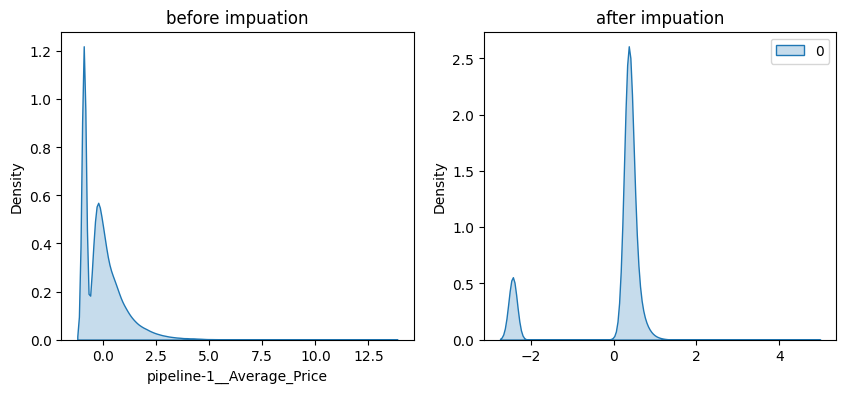

In [295]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
sns.kdeplot(StandardScaler().fit_transform(np.array(df['Average_SP_LP']).reshape(-1, 1)), fill = True, ax=ax[1])
ax[0].set_title("before impuation")
sns.kdeplot(train_df['pipeline-1__Average_Price'], fill = True, ax=ax[0])
ax[1].set_title("after impuation")
plt.show()

In [299]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [300]:
y_pred = lr.predict(X_test)
print('r2 score :', r2_score(y_pred=y_pred, y_true=y_test))
print('mean_squared_error :', mean_squared_error(y_pred=y_pred, y_true=y_test))
print('mean_absolute_error :', mean_absolute_error(y_pred=y_pred, y_true=y_test))

r2 score : 0.8114044981980907
mean_squared_error : 0.18001968269520063
mean_absolute_error : 0.2693939709000402


In [301]:
tree = DecisionTreeRegressor()

tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [304]:
y_pred = tree.predict(X_test)
print('r2 score :', r2_score(y_pred=y_pred, y_true=y_test))
print('mean_squared_error :', mean_squared_error(y_pred=y_pred, y_true=y_test))
print('mean_absolute_error :', mean_absolute_error(y_pred=y_pred, y_true=y_test))

r2 score : 0.9942216156618513
mean_squared_error : 0.005515629509218361
mean_absolute_error : 0.012999978930774496


In [306]:
GBR = GradientBoostingRegressor()

GBR.fit(X_train, y_train)

GradientBoostingRegressor()

In [307]:
y_pred = GBR.predict(X_test)
print('r2 score :', r2_score(y_pred=y_pred, y_true=y_test))
print('mean_squared_error :', mean_squared_error(y_pred=y_pred, y_true=y_test))
print('mean_absolute_error :', mean_absolute_error(y_pred=y_pred, y_true=y_test))

r2 score : 0.9897899326815385
mean_squared_error : 0.00974579489651158
mean_absolute_error : 0.04747853751128085


In [310]:
gbr_cv = cross_val_score(estimator=GBR, X=X_test, y=y_test, cv = 10)

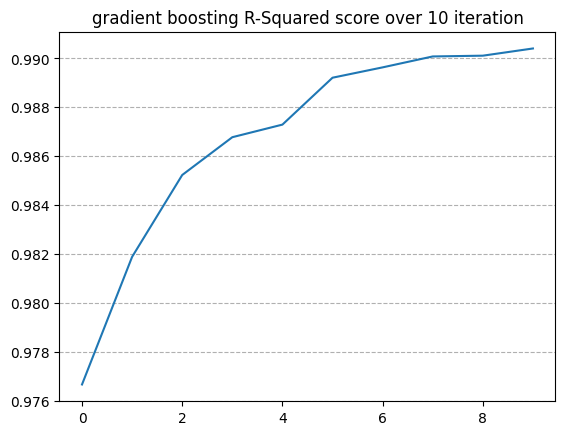

In [394]:
sns.lineplot(x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], y = gbr_cv)
plt.title('gradient boosting R-Squared score over 10 iteration')
plt.grid(axis = 'y', ls = '--')
plt.show()

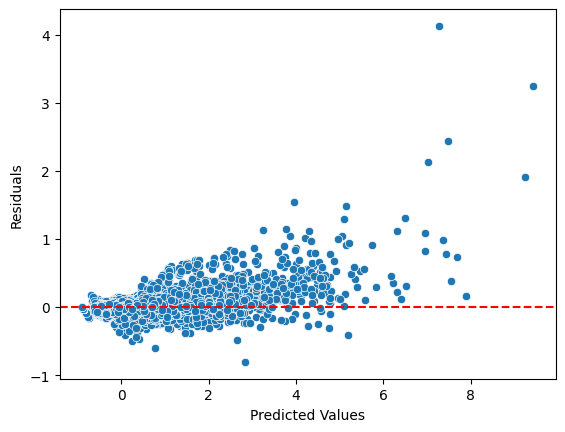

In [431]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [601]:
def FinalANN(X_train, y_train, X_test, y_test, lr, batch_size: int, num_epochs: int, Save_model: bool):
    # Data preparation 
    X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
    X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.array(y_train), dtype=torch.float32)
    y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32)
    
    train_tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_tensor_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_dataloader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle = True)
    
    # model architecture
    class RegressionNeuralNetwork(nn.Module):
        def __init__(self, input_shape):
            super(RegressionNeuralNetwork, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_shape, 16),
                nn.ReLU(),
                nn.Linear(16, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
            
        def forward(self, x):
            return self.layers(x)
    
    input_shape = X_train_tensor.shape[1]
    model = RegressionNeuralNetwork(input_shape=input_shape)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)  
    
    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience = 5
    patience_counter = 0

    # Training phase
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train_loss = 0.0
        
        for ipt, y_true in train_dataloader:
            optimizer.zero_grad()
            output = model(ipt)
            loss = criterion(output, y_true.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_test_loss = 0.0
        with torch.no_grad():
            for ipt, y_true in test_dataloader:
                output = model(ipt)
                loss = criterion(output, y_true.unsqueeze(1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)
        
        print(f"[{epoch}/{num_epochs}] | Train loss: {avg_train_loss:.6f} | Test loss: {avg_test_loss:.6f}")
        
        # Early stopping
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            patience_counter = 0
            if Save_model:
                torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        if avg_train_loss < 0.001:
            print(f"Reached target loss at epoch {epoch}")
            break
    
    # Final evaluation
    model.eval()
    mse = MeanSquaredError()
    r2 = R2Score()
    
    with torch.no_grad():
        for ipt, y_true in test_dataloader:
            output = model(ipt)
            mse.update(output, y_true.unsqueeze(1))
            r2.update(output, y_true.unsqueeze(1))

    return train_losses, test_losses, mse.compute().cpu().numpy(), r2.compute().cpu().numpy()
    

train_losses, test_losses, eval_mse, eval_r2 = FinalANN(
    X_train, y_train, 
    X_test, y_test, 
    lr = 0.00001, 
    batch_size= 64, 
    num_epochs= 100, 
    Save_model=False
)

[1/100] | Train loss: 0.829037 | Test loss: 0.583182
[2/100] | Train loss: 0.476268 | Test loss: 0.297045
[3/100] | Train loss: 0.267039 | Test loss: 0.172973
[4/100] | Train loss: 0.167235 | Test loss: 0.107557
[5/100] | Train loss: 0.118433 | Test loss: 0.069433
[6/100] | Train loss: 0.094943 | Test loss: 0.061120
[7/100] | Train loss: 0.083163 | Test loss: 0.049269
[8/100] | Train loss: 0.073526 | Test loss: 0.042261
[9/100] | Train loss: 0.066943 | Test loss: 0.039962
[10/100] | Train loss: 0.063229 | Test loss: 0.037038
[11/100] | Train loss: 0.058048 | Test loss: 0.035350
[12/100] | Train loss: 0.053428 | Test loss: 0.033452
[13/100] | Train loss: 0.051720 | Test loss: 0.032118
[14/100] | Train loss: 0.049983 | Test loss: 0.030511
[15/100] | Train loss: 0.046162 | Test loss: 0.029163
[16/100] | Train loss: 0.044536 | Test loss: 0.028229
[17/100] | Train loss: 0.043531 | Test loss: 0.027614
[18/100] | Train loss: 0.041516 | Test loss: 0.026897
[19/100] | Train loss: 0.040378 | Tes

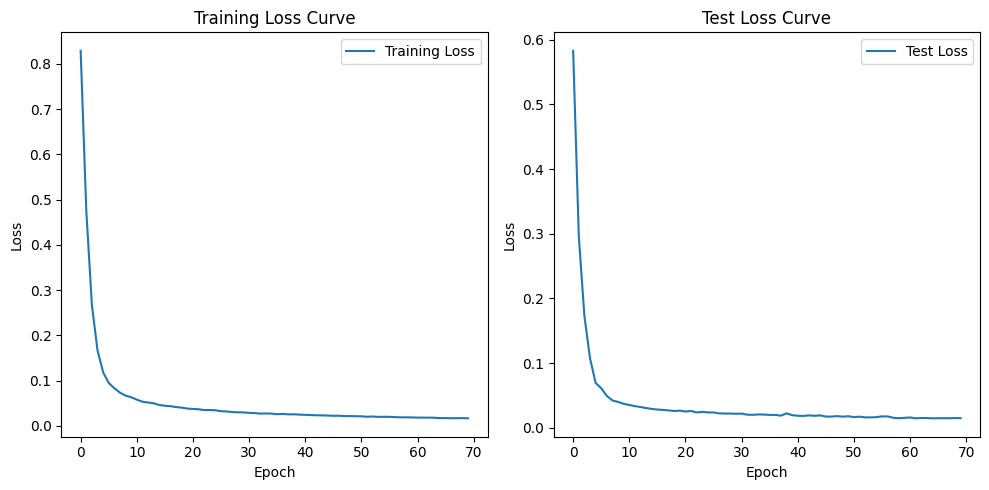

In [602]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot([float(i) for i in train_losses], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([float(i) for i in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [609]:
print("mean_squared_error:", eval_mse)
print("R2 Score:",eval_r2)

mean_squared_error: 0.014850256
R2 Score: 0.9844423


# THANK YOU